In [1]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit
from scipy.stats import linregress
from scipy.stats import nbinom
import warnings
warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from numba import njit
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


In [3]:
from numba import njit
@njit
def energyscore_multipletargets(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum(((X[i]-y)/y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum(((X[i]-X[j])/y)**2))/(2*N**2)
    return ES


In [148]:
# toy example
hosp = np.array([np.array([90, 96]), np.array([105, 110])])
case = np.array([np.array([950, 1001]), np.array([110, 103])])
death = np.array([np.array([5,6]), np.array([12,9])])

X1 = np.array([hosp[0], case[0], death[0]])
X2 = np.array([hosp[1], case[1], death[1]])
A = np.array([X1, X2])

obsh = np.array([100, 103])
obsc = np.array([1000, 999])
obsd = np.array([10, 11])

obs = np.array([obsh, obsc, obsd])
X = np.array([hosp, case, death])

In [147]:
energyscore_multipletargets(A, obs)

0.6276617436085661

# Flu SMH

In [4]:
def pull_flu_scenario_modeling_hub_predictions(model,dates):
    """pull_scenario_modeling_hub_predictions. Load predictions of the model saved by the scenario modeling
    hub.

    Parameters  
    ----------
    model : str
        Model name on thhe
    dates : list or string
        List of potential dates in the iso format, e.g., 'yyyy-mm-dd', for the submission.
    """
    predictions = None
    if isinstance(dates,str):
        dates = [dates]
    for date in dates:
        url = f"https://raw.githubusercontent.com/midas-network/flu-scenario-modeling-hub/master/data-processed/{model}/{date}-{model}"
        for ext in [".gz.parquet", ".parquet"]:
                try:
                    predictions = pd.read_parquet(url+ext)
                    
                except:
                    pass

    if predictions is None:
        print(f"Data for model {model} and date {dates} unavailable")
    return predictions


# Multitarget energy score for MOBS model

In [6]:
# use Flu SMH data and shuffle trajectory matrices for hospitalizations in all states and calculate energy score
# for different matrix formulations

In [ ]:
modelmap = {'MOBS_NEU-GLEAM_FLU':'Model A', 'NIH-Flu_TS': 'Model B','NotreDame-FRED':'Model C',
            'PSI-M2':'Model D', 'USC-SIkJalpha':'Model E', 'UT-ImmunoSEIRS':'Model F'}

In [10]:
# include all models, even those only submitting for one location
modelsall = ['MOBS_NEU-GLEAM_FLU']

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(hosp.date.max())


predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    df = pull_flu_scenario_modeling_hub_predictions(model,'2023-09-03')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    df['Model'] = model
    df['trajectory_id'] = df['output_type_id'] + 100*i
    
    numweeks = list(df.horizon.unique())
    start_date = list(df.origin_date.unique())[0]
    date_1 = pd.to_datetime(start_date)

    alldates = []
    for wk in numweeks:
        if wk==1:
            d = date_1 + timedelta(days=6*int(wk))
        else:
            d = pd.to_datetime("2023-09-02") + timedelta(weeks=int(wk))

        alldates.append(d)

    dfdates = pd.DataFrame({'horizon':numweeks, 'target_end_date':alldates}) # add date of prediction to dataframe
    df = df.merge(dfdates, how='inner', on='horizon')

    predictionsall = pd.concat([predictionsall, df])
    i += 1
    
    
# filter by dates with data
predictionsall = predictionsall[predictionsall.target_end_date <= max_date]    
     
    

In [79]:
dfmobs = predictionsall[(predictionsall.Model=='MOBS_NEU-GLEAM_FLU') & (predictionsall.target=='inc hosp')]

In [189]:
#hospitalizations
target = 'hospitalization'
incidence=True
hosp = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target}.pq")
hosp['date'] = pd.to_datetime(hosp['date'])
hosp = hosp[(hosp.date>pd.to_datetime('2023-11-18'))].sort_values(by=['date']).reset_index().drop(columns=\
                                                                        ['Unnamed: 0', 'index','weekly_rate'])

hosp = hosp[(hosp.location != '72') &(hosp.location!='66')]
#h = np.array(hosp['value'])
#obs = np.array([h,d])

In [156]:
obs = np.array([np.array(hosp[hosp.location == i].value) for \
                     i in hosp.location.unique()])
locations = list(hosp.location.unique())

In [160]:

energyscores_locations = pd.DataFrame()
for it in range(100):
    for model in ['MOBS_NEU-GLEAM_FLU']:
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:

            loc_array ={}
            j=0
            for loc in locations:
                if loc in ['72', '66']:
                    continue
                predictionshosp = dfmobs[(dfmobs.scenario_id == scenario + '-2023-08-14') & \
                                            (dfmobs.target_end_date <= hosp.date.max()) & \
                                            (dfmobs.target_end_date >= hosp.date.min())&\
                                            (dfmobs.Model == model) &\
                                            (dfmobs.location==loc)]

                newid = random.sample(list(predictionshosp['trajectory_id']), 
                                      k=len(list(predictionshosp['trajectory_id'])))
                predictionshosp['new_id'] = newid

                Xhosp = np.array([np.array(predictionshosp[predictionshosp.new_id == i].value) for \
                         i in predictionshosp.new_id.unique()])
                
                loc_array[loc] = Xhosp
                
                j+=1
                
            A = []
            for i in range(len(Xhosp)):
                B = []
                for loc in locations:
                    if loc in ['72', '66']:
                        continue
                    B.append(loc_array[loc][i])
                B = np.array(B)
                A.append(B)

            A = np.array(A)



            ES = energyscore_multipletargets(A,obs)


            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':'US',  
                                 'energyscore': ES, 'it':it}, index=[0])

            energyscores_locations = pd.concat([energyscores_locations, newrow])

energyscores_locations = energyscores_locations.reset_index().drop(columns=['index'])  

In [372]:
energyscores_locations.to_csv('../fludat/multitarget_loc_MOBS.csv')

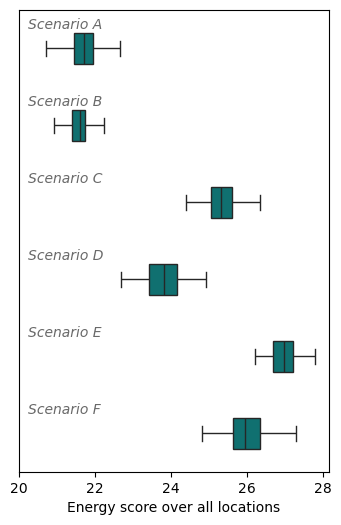

In [333]:
# plot multi-target energy score across all locations just for MOBS model
fig, ax = plt.subplots(1,1,figsize=(4,6), sharex=True)

my_order = list(energyscores_locations.Label.unique())
sns.boxplot(x='energyscore', y='Label', data=energyscores_locations, width=.4, showfliers=False, color='teal')
plt.ylabel('')
plt.yticks([])
plt.xlabel('Energy score over all locations')

a=0
for mod in list(my_order):
    plt.text(20.25,a-.25, mod, fontsize=10, style='italic', color='dimgray')
    a+=1

plt.xticks([20, 22, 24, 26, 28])

plt.savefig('../figs/mulitargets_locations_MOBS.pdf')

21.70863350193692
21.609592047440902
25.32603107277785
23.813863628749694
26.973543752561504
25.945745086242425


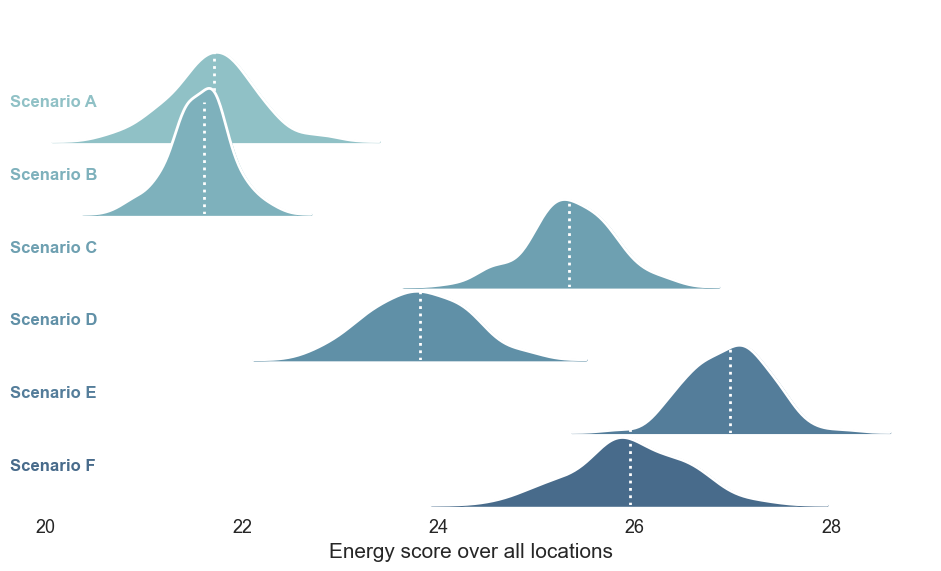

In [451]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})


# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(energyscores_locations, row="Label", hue="Label", aspect=10, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "energyscore",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "energyscore", clip_on=False, color="w", lw=2, bw_adjust=1)

# passing color=None to refline() uses the hue mapping
#g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .3, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "energyscore")

# Define a function to plot the median
def plot_median(data, color, label):
    median = np.median(data['energyscore'])
    plt.axvline(median,ymin=0, ymax=.85, color='white', linestyle=':', linewidth=2)
    print(median)
    
# Apply the function to plot the median
g.map_dataframe(plot_median)


# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)


#plt.xlim([-45, 32])
plt.xlabel('Energy score over all locations', fontsize=15)
plt.xticks(fontsize=13)
#plt.ylabel('% infectious-detectable \n stopped '+r'from traveling, $\phi_b$', y=1.1, fontsize=12)

plt.savefig('../figs/multitarget_MOBS_kdeplot.pdf')
plt.show()

# Energy score for multiple targets for all models

In [163]:
dfall = predictionsall[(predictionsall.target=='inc hosp')]

In [271]:
energyscores_locall = pd.DataFrame()
for it in range(100):
    print(it)
    for model in ['MOBS_NEU-GLEAM_FLU', 'NotreDame-FRED', 'USC-SIkJalpha', 'UT-ImmunoSEIRS',
                  'NIH-Flu_TS', 'PSI-M2']:
        #print(model)
        for scenario in ['D']:

            loc_array ={}
            j=0
            for loc in locations:
                if loc in ['72', '66', '69','60', '78']:
                    continue
                predictionshosp = dfall[(dfall.scenario_id == scenario + '-2023-08-14') & \
                                            (dfall.target_end_date <= hosp.date.max()) & \
                                            (dfall.target_end_date >= hosp.date.min())&\
                                            (dfall.Model == model) &\
                                            (dfall.location==loc)]
                hospfilt = hosp[hosp.location.isin(dfall[dfall.Model==model].location.unique())]
                obsnew = np.array([np.array(hospfilt[hospfilt.location == i].value) for \
                     i in hospfilt.location.unique()])
                

                newid = random.sample(list(predictionshosp['trajectory_id']), 
                                      k=len(list(predictionshosp['trajectory_id'])))
                predictionshosp['new_id'] = newid
                
                if len(predictionshosp)==0:
                    continue

                Xhosp = np.array([np.array(predictionshosp[predictionshosp.new_id == i].value) for \
                         i in predictionshosp.new_id.unique()])
                
                loc_array[loc] = Xhosp
                
                j+=1
                
            A = []
            for i in range(len(Xhosp)):
                B = []
                for loc in loc_array.keys():
                    if loc in ['72', '66']:
                        continue
                    if len(loc_array[loc]) ==0:
                        continue
                        
                    B.append(loc_array[loc][i])
                B = np.array(B)
                A.append(B)

            C = np.array(A)



            ES = energyscore_multipletargets(C,obsnew)


            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 
                                 'energyscore': ES, 'it':it}, index=[0])

            energyscores_locall = pd.concat([energyscores_locall, newrow])

energyscores_locall = energyscores_locall.reset_index().drop(columns=['index'])  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [272]:
energyscores_locall.to_pickle('../fludat/energyscore_mt_locations_scenD_101.pkl')

In [273]:
energyscores_locall

,Model,Label,energyscore,it
0,MOBS_NEU-GLEAM_FLU,Scenario D,24.172093,0
1,NotreDame-FRED,Scenario D,80.541757,0
2,USC-SIkJalpha,Scenario D,32.212616,0
3,UT-ImmunoSEIRS,Scenario D,206.891566,0
4,NIH-Flu_TS,Scenario D,15.370926,0
...,...,...,...,...
595,NotreDame-FRED,Scenario D,82.186272,99
596,USC-SIkJalpha,Scenario D,31.873464,99
597,UT-ImmunoSEIRS,Scenario D,208.393589,99
598,NIH-Flu_TS,Scenario D,15.600847,99


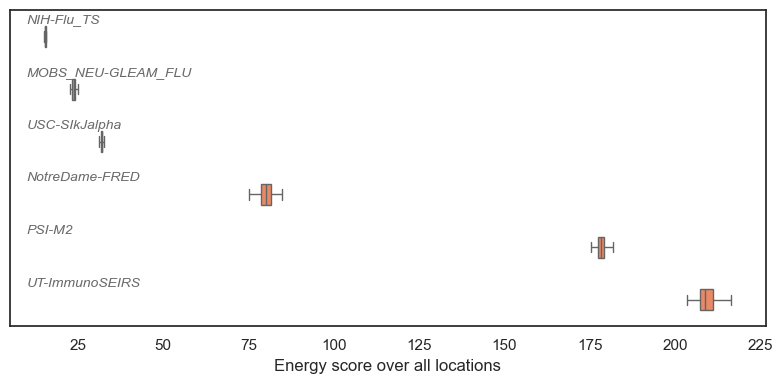

In [403]:
fig, ax = plt.subplots(1,1,figsize=(8,4), sharex=True)

#df= energyscores_locall

my_order = energyscores_locall.groupby(by=["Model"])["energyscore"].median().sort_values(ascending=True).index
ges = sns.boxplot(x='energyscore', y='Model', data=energyscores_locall, width=.4,order=my_order, 
            showfliers=False, color='coral')
plt.ylabel('')
plt.xlabel('Energy score over all locations')


ges.set(yticklabels=[])
ges.set(yticks=[])
ges.set(ylabel=None)
#ges.set(xlabel=None)
#ges.set(xticklabels=[])
#ges.set(xticks=[2.5, 5, 10, 15, 20])
#plt.xlim([0,800])

a = 0
for mod in list(my_order):
    plt.text(10,a-.25, mod, fontsize=10, style='italic', color='dimgray')
    a+=1

#plt.xscale('log')

#plt.xlim([0,100])
plt.tight_layout()
plt.show()

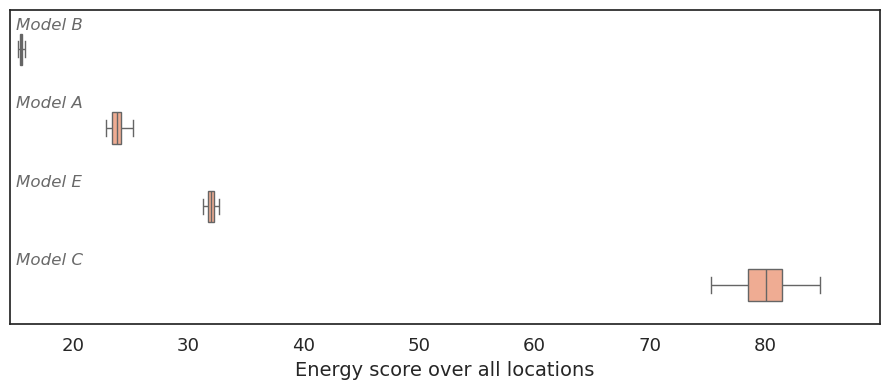

In [449]:
fig, ax = plt.subplots(1,1,figsize=(9,4), sharex=True)
mpl.rc_file_defaults()
df= energyscores_locall[(energyscores_locall.Model != 'PSI-M2') & (energyscores_locall.Model != 'UT-ImmunoSEIRS')]

my_order = df.groupby(by=["Model"])["energyscore"].median().sort_values(ascending=True).index
ges = sns.boxplot(x='energyscore', y='Model', data=df, width=.4,order=my_order, 
            showfliers=False, color='coral')
plt.ylabel('')
plt.xlabel('Energy score over all locations', fontsize=14)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .7))

ges.set(yticklabels=[])
ges.set(yticks=[])
ges.set(ylabel=None)
#ges.set(xlabel=None)

#ges.set(xticks=[20, 40, 60, 80], xticklabels=[20, 40, 60, 80])
#ges.set(xticklabels=[])
plt.xlim([10,90])

a = 0
for mod in list(my_order):
    plt.text(15,a-.25, modelmap[mod], fontsize=12, style='italic', color='dimgray')
    a+=1

#plt.xscale('log')
#plt.xticks([20, 40, 60, 80])
#plt.xticks([20, 40, 60, 80])

plt.xlim([14.5,90])
plt.xticks([20, 30,40, 50,60,70, 80], fontsize=13)
ges.set(xticks=[20, 30,40, 50,60,70, 80], xticklabels=[20, 30,40, 50,60,70, 80])
plt.tight_layout()

#plt.savefig('../figs/multitarget_locations_models_103.pdf')
plt.show()

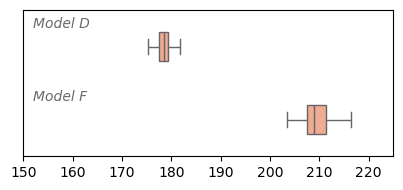

In [450]:
fig, ax = plt.subplots(1,1,figsize=(4,2), sharex=True)

df= energyscores_locall[(energyscores_locall.Model.isin(['PSI-M2', 'UT-ImmunoSEIRS'])) ]

my_order = df.groupby(by=["Model"])["energyscore"].median().sort_values(ascending=True).index
ges = sns.boxplot(x='energyscore', y='Model', data=df, width=.4,order=my_order, 
            showfliers=False, color='coral')

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .7))


plt.ylabel('')
plt.xlabel('')


ges.set(yticklabels=[])
ges.set(yticks=[])
ges.set(ylabel=None)
#ges.set(xlabel=None)
#ges.set(xticklabels=[])
#ges.set(xticks=[20, 40, 60, 80])
plt.xlim([10,225])

a = 0
for mod in list(my_order):
    plt.text(152,a-.25, modelmap[mod], fontsize=10, style='italic', color='dimgray')
    a+=1

#plt.xscale('log')
#plt.xticks([150,175,200,225])

plt.xlim([150,225])

plt.tight_layout()
plt.savefig('../figs/multitarget_locations_models_inset.pdf')

plt.show()